# Off-policy Monte Carlo

Mario Fiorino

L'apprendimento off-policy utilizza due policy:

- una detta target policy , appresa durante il training, è progettata per avvicinarsi alla policy ottimale. Spesso indicata con $\pi$

- una behavior policy, o "esplorativa", che viene utilizzata per generare dati (o comportamenti). Spesso indicata con $b$



Si ricorda che i metodi on-policy (visti nel notebook precedente) aggiornano la stessa politica ad ogni iterazione al fine di ottenere una politica che converge verso la politica ottimale. Tale l’approccio on-policy è di fatto un compromesso. Non apprende la politica ottimale, ma una politica quasi-ottimale (near-optimal), che cioè continua ad esplorare.

Si ricorda inoltre che i metodi Montecarlo non richiedono la conoscenza della funzione di probabilità di transizione; cioè di un modello che mette in relazione gli stati con le azioni e ci permette di formulare previsioni.


$\;$

Prerequisiti per capire questo notebook

Leggere almeno l'introduzione del notebook precedente: https://github.com/MarioFiorino/Tutorial-Reinforcement-Learning-ITA-Python/blob/main/Metodi_Monte_Carlo_RL_ITA.ipynb


$\;$

Ref

Reinforcement Learning: An Introduction

Richard S. Sutton and Andrew G. Barto, Second Edition - MIT Press, Cambridge, 2018.

$\;$

*

Come introduzione, può esser d'aiuto anche il video:

https://www.youtube.com/watch?v=bpUszPiWM7o


In questo video troverete anche una versione più intuitiva dell'algoritmo Off-Policy Monte Carlo Control (min 21.55), rispetto a quella introdotta in questo notebook.

## Premessa statistica: Incremental v.s non-incremental  

E' possibile utilizzare entrambi i metodi: incrementale e non-incrementale,  per il ricavare la stima del'expected value $\mathbb{E}[X]$ di una certa variabile random $X$.




Gli algoritmi che abbiamo visto nel notebook precedente, sono basati su update non incrementale. Ovvero, raccolgono prima tutti i campioni: $\{x_{i} \}^{n} _{i=1}$

e poi  calcolano la media:

$\mathbb{E}[X] \approx \frac{1}{n} \sum_{i=1}^{n} x_{i} $

Questo metodo presenta lo svantaggio che, se il numero di campioni è elevato, l'attesa per il calcolo della media può essere lunga; e lo spazio di memoria necessario molto elevato.

I metodi incrementali, invece, calcolano la media in modo computazionalmente più efficiente. Come? Sfruttando la formulazione:

$w_{n}  \;  \doteq \; \frac{1}{n-1}  \sum_{i=1}^{n-1} x_{i} $


$w_{n+1}  \; =  \; w_{n} + \frac{1}{n}   \;   (x_{n} − w_{n})  \; = \; \frac{1}{n}  \sum_{i=1}^{n} x_{i} $



Ovvero la media di un certo passo $n$ è ottenuta dalla media del passo precedente $n-1$ e aggiornata con le nuove osservazioni $x_{n}$.

Per un esempio pratico , sia $w_{1} = a $ , un valore del tutto arbitrario.

$w_{2}  =  \; w_{1} + \frac{1}{1}   \;   ( x_{1} - w_{1} ) = x_{1} $

$w_{3}  =  \; w_{2} + \frac{1}{2}   \;   (x_{2} - w_{2}) = \frac{1}{2}   \;   (x_{1} + x_{2}) $

$w_{4}  =  \; w_{3} + \frac{1}{3}   \;   (x_{3} - w_{3}) = \frac{1}{3}   \;   (x_{1} + x_{2} + x_{3}) $

e così via ....  $w_{n+1}  = \frac{1}{n}  \sum_{i=1}^{n} x_{i}$



Per le manipolazioni simbolico-matematiche che dimostrano la validità della formula, vedi il testo di Sutton e Barto, Second Edition, pag PDF 53.


Il vantaggio di questa equazione è che consente di calcolare la media immediatamente, ogni volta che si riceve un nuovo campione; in più questa implementazione richiede memoria solo per i dati $w_{n}$ e $n$.


$\;$





## MC prediction problem (policy evaluation)


In tale fase,  rigurado la target policy $\pi$ e la behavior policy $b$, si fa un assunzione  di "coverage", ovvero :

$∀a  \; \pi(a|s) > 0 \implies b(a|s) > 0 $

cioè, in un certo stato $s$, per ogni azione $a$ che ha un probablità positva di essere estratta da $\pi$ , deve esistere una possibilità (eventualemente anche minima) che tale azione $a$ venga estratta anche da $b$.
Nella pratica si assume che $b$ sia una soft-policy.


I metodi Monte-Carlo cercano di calcolare expected returns $V_{\pi}$ della target policy; tutto ciò che abbiamo però sono i return $G_{t}$ (e quindi una approssimazione di $V_{b}$) della
behavior policy.

Problema :

come ricavare $V_{\pi}$ della target policy in base al campiomentno dei return $G_{t}$ della
behavior policy ?

Qui entra in gioco la tecnica **Importance sampling** :

in termini statistici, è una tecnica Monte Carlo che consente di stimare le proprietà di una distribuzione di probabilità, anche se si dispone solo di campioni generati da una distribuzione diversa. In pratica, l'importance sampling consiste nel generare campioni dalla distribuzione diversa, e poi nel pesare i campioni in base alla probabilità che avrebbero avuto se fossero stati generati dalla distribuzione di interesse. Per maggiori info : https://en.wikipedia.org/wiki/Importance_sampling


Si consideri la probalità del verificarsi una certa traiettoria, dato lo stato di partenza $s_{t}$, seguendo una certa  policy $\pi$

$\prod_{k=t}^{T-1} \pi(a_{k}|s_{k}) p (s_{k+1}|s_{k},a_{k} ) = \pi(a_{t}|s_{t}) p (s_{t+1}|s_{t},a_{t}) \;\cdot \; \pi(a_{t+1}|s_{t+1}) p (s_{t+2}|s_{t+1},a_{t+1}) \;\cdot \; ... \;\cdot \;
 \pi(a_{T-1}|s_{T-1}) p (s_{T}|s_{T-1},a_{T-1}) \;   $

Dove $p$ è la probabilita di transizione (transition probability function : la probabilità di passare allo stato $s_{k+1}$ se inizi dallo stato $s_{k}$ e intraprendi l'azione $a_{k}$ ); mentre $S_{T}$ è uno stato terminale.

Il rapporto tra la probabilità del verificarsi di una certa traiettoria sotto una certa policy e la probabilità del verificarsi della stessa traiettoria sotto una pocily diversa, nel nostro caso le due policy sono target e behavior,  è detto, **importance sampling ratio**:

$\rho_{t:T-1} = \prod_{k=t}^{T-1}  \frac{ \pi(a_{k}|s_{k})}{ b (a_{k}|s_{k})} $



Vedremo come questo rapporto è fondamentale perché corregge il "bias" introdotto dal campionamento da una distribuzione diversa.

Per il ragionamento matematico che ha portato a tale formulazione, per maggiori chiarimenti e integrazioni teoriche, anche per i passaggi successivi, vedere i video:

https://www.youtube.com/watch?v=jbnoyCLY9cI&t=10s

https://www.youtube.com/watch?v=xpevq9jBi7o&t=10s

$\;$


L'importance sampling ratio ci consente di stimare expected value della target policy, disponendo del campionamento dei return $G_{t}$ della behavior policy, in simboli:

$\mathbb{E}[\rho_{t:T-1} \cdot G_{t} | S_{start}] =  V_{\pi}(S_{start}) $

La formula qui sopra, di natura del tutto generale, si può concretizzare nel seguente modo:

Assumedo che stiamo usando un algoritmo del tipo MC first-visit.

Assumiamo inoltre che utilizziamo la suddivisione degli episodi in base all'idea : "It is convenient here to number time steps in a way that increases across episode boundaries." suggerita da Sutton e Barto, Second Edition, PDF 126. Tale idea comporta le seguenti rappresentazioni:

$\Im(s)$ indica l'insime dei time step in cui un certo stato $s$ è stato visitato per la prima volta all'interno dei loro rispettivi episodi. Esempio, un certo stato $s'$ , se è stato visitato al time step t = 3 nel primo episodio, poi la time step t = 20 nel secondo, poi nel terzo t=45, ed infine al t=1023 nel decino episodio. Allora, $\Im(s') = \{3,20,45,1023\} $


$T(t)$ indica il primo time-step terminale, incontrato nell'episodio con il time-spep $t$ . Esempio se l'episodio contente il time-step $t = 3$ termina al time-step $10$, allora $T(3) = 10$.

$G_{t}$ indica il return ottenuto partendo dal time step $t$ fino a quello terminale $T(t)$.


$\{G_{t}\}_{t \in \Im(s)}$ indica l'insime di tutti i return che partono dalla state $s$. Nel nostro esempio, considerando lo stato $s'$,allora abbiamo: $\{G_{t}\}_{t \in \Im(s')} = \{G_{t=3}, G_{t=20}, G_{t=45}, G_{t=1023} \}$



$\{\rho_{t:T(t)-1} \}_{t \in \Im(s)}$ denota l'insime dei relativi importance-sampling ratio della policy target e behavior. Ovvero, sempre considernado il nostro esempio, partendo dallo stato $s'$, entrambe le policy target e behavior producono una certa probabilità di estrarre una data traiettoria (uguale per entrambe, e che quindi si conclude nel rispettivo stato terminale $T(t)$). In simboli:  $\{\rho_{t:T(t)-1} \}_{t \in \Im(s')} = { \{ \rho_{3:9}}, \rho_{20:T(20)-1}, \rho_{45:T(45)-1}, \rho_{1023:T(1023)-1}  \}$

$\;$

Infine , per stimare expected value della target policy, disponendo del campionamento dei return $G_{t}$ della behavior policy, usiamo la formula:

$V_{\pi}(s) = \frac{\sum_{t \in \Im(s)} \rho_{t:T(t)-1} \cdot G_{t} } {\lvert \Im(s) \rvert} $

Dove $\lvert \Im(s) \rvert$, denota la cardinalità di un insieme, ovvero il numero di elementi contenuto nell'insieme; in pratica, il numero di volte che un certo stato $s$ è stato visitato la prima volta durante il training.

Considerando il nostro esempio, per lo stato $s'$, la formula diventa:

$V_{\pi}(s') ≈ \frac{ \rho_{3:9} \cdot G_{3} } {4}  + \frac{ \rho_{20:T(20)-1} \cdot G_{20} } {4}  +  \frac{ \rho_{45:T(45)-1} \cdot G_{45} } {4} + \frac{ \rho_{1023:T(1023)-1} \cdot G_{1023} } {4}$


Quando $V_{\pi}(s)$ viene stimato in questo modo, diciamo che stiamo usando lo stimatore: **ordinary importance sampling**.

$\;$

Capire il tutto con un esempio pratico.


La cosa si puo capire facilmente con un esempio molto semplice di un ambinete, con funzione di transizione di stato $p=1$, con soli due stati, o meglio celle contigue, una iniziale e finale: $s_{0}$ e $s_{T}$, ed due sole azioni $d$ e $alt$, ovvero "vai a destra" e "resta fermo". Reward = $+1$ ottenuto nella cella $s_{T}$, altrimenti $0$. Il fattore gamma = 1.

La target policy ha la seguente distribuzione di probabilità:

$\pi(d |s_{0}) = 0.6$

$\pi(alt |s_{0}) = 0.4 $

mentre la behavior:

$b(d |s_{0}) = 0.2$

$b(alt |s_{0}) = 0.8$


Campioniamo 10 traiettorie dalla behavior:

1. $s_{0},a_{d},s_{T}$

2. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

3. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

4. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

5. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

6. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

7. $s_{0},a_{alt},a_{d},s_{T}$

8. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

9. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

10. $s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{alt},s_{0},a_{d},s_{T}$

Abbiamo 10 elementi $G_{t}$ con valore $1$

Ricaviamo i rispettivi importance sampling ratio delle due distribuzioni, per ogni  traiettoria che parte $s_{0}$ , first-visit:

1. $\rho^{1} = \frac{0.6}{0.2} = 3 $

2. $\rho^{2} = \frac{0.4 * 0.4 * 0.6}{0.8 * 0.8 *0.2} = 0.75 $

3. $\rho^{3} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4* 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.0239$

4. $\rho^{4} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.187 $

5. $\rho^{5} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4* 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.0239$

6. $\rho^{6} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4* 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.0239$

7. $\rho^{7} = \frac{0.4 * 0.6}{0.8 *0.2} = 1.5 $

8. $\rho^{8} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.187 $

9. $\rho^{9} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4 * 0.4* 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.0239$

10. $\rho^{10} = \frac{0.4 * 0.4 * 0.4 * 0.4 * 0.6}{0.8 * 0.8 * 0.8 * 0.8 * 0.2} =  0.187 $


Una stima dell'expected return della policy target:

$ V_{\pi}(s_{0}) \approx  \frac{3 + 0.75 + 0.0239 + 0.187 + 0.0239 + 0.0239 + 1.5 +  0.187  + 0.0239 + 0.187 }{ 10 } = 0.59 $

Un valore molto vicino al valore vero $ V_{\pi}(s_{0}) = 0.6$

Se invece, avessimo avuto campionamento di traiettorie differenti,in $10$ traiettorie campionate da $b$ :

-   $ V_{\pi}(s_{0}) \approx 0.0239 ⋅ 10 / 10 = 0.23 $.

-   $ V_{\pi}(s_{0}) \approx (3⋅3) + 1.5 + (0.0239 ⋅ 6) / 10 = 1.07 $.


L'ordinary importance sampling,  è uno stimatore "unbiased" ma ha una varianza "unbounded", ovvero non limitata: cioè puo essere molto alta, come si intuisce dal semplice esempio, legata alla varianza della distribuzione dei ratio (da 3 a 0.0239), che produce dei valori $ V_{\pi}(s_{0})$ molto diversi.


$\;$



Introduciamo uno stimatore alternativo **weighted importance sampling**:


$V_{\pi}(s) = \frac{\sum_{t \in \Im(s)} \rho_{t:T(t)-1} \cdot G_{t} } {\sum_{t \in \Im(s)} \rho_{t:T(t)-1}} $


Nell'esempio di partenza avremo:

$V_{\pi}(s') ≈ \frac{1} {\rho_{3:9} +  \rho_{20:T(20)-1} + \rho_{45:T(45)-1} + \rho_{1023:T(1023)-1} }  \cdot ( \; (\rho_{3:9} \cdot G_{3}) +  (\rho_{20:T(20)-1} \cdot G_{20})  +  (\rho_{45:T(45)-1} \cdot G_{45}) + (\rho_{1023:T(1023)-1} \cdot G_{1023})  \;)$


Considenrando adesso l'esempio pratico, e le $10$ traiettorie campionate da $b$ in precedenza, avremo:

$ V_{\pi}(s_{0}) \approx \frac{5.9}{5.9}  =  G_{t} = 1  $  che è un risultato che ha un sè un errore sistematico, ma è indipendente dalla varianza dei ratio.

Se nello stesso ambinete avremo avuto due reward; $R(s_{T}) = +1$ e $R(s_{0}) = - 0.1$.


Allora: $ V_{\pi}(s_{0}) \approx \frac{3 + (0.75 \cdot 0.8 )+ (0.0239 \cdot 0.3)  + ( 0.187 \cdot 0.6) +(0.0239 \cdot 0.3)  + (0.0239 \cdot 0.3)  + (1.5 \cdot 0.9) +  ( 0.187 \cdot 0.6)  + (0.0239 \cdot 0.3)  + ( 0.187 \cdot 0.6) }{5.9} = 0.9 $


Oppure, campionando traiettorie diverse:

 - $ V_{\pi}(s_{0}) \approx \frac{(1.5 \cdot 0.9) + ((0.0239 \cdot 0.3) ⋅ 9)}{ 1.71}  = 0.82 $.

 - $ V_{\pi}(s_{0}) \approx \frac{(3⋅3) + (1.5 \cdot 0.9) + ((0.0239 \cdot 0.3) ⋅ 6)}{ 10.65}  = 0.97 $.

Si puo notare che lo stimatore in senso statistico è "biased"; ma ha una varianza piccola.


$\;$


*

Weighted importance sampling v.s. Ordinary importance sampling

Nella pratica il weighted importance sampling è preferito all’ordinary importance sampling  nell’off-policy learning, perché può produrre stime con una varianza molto inferiore.

Nel testo di Sutton e Barto, Second Edition, PDF 127, si legge:


" Ordinary importance sampling is unbiased whereas weighted importance sampling is biased, though the bias converges asymptotically to zero" ( significa che la distorsione dello stimatore weighted importance si avvicina sempre di più allo zero all’aumentare del numero di campioni (tale stimatore è consistente).


" In practice, the weighted estimator usually has dramatically lower variance and is strongly preferred "

ed a pag PDF 128:

" The estimates of ordinary importance sampling will
typically have infinite variance, and thus unsatisfactory convergence properties, every time that
the scaled returns (cioè il " ratio$\cdot G_{t}$ ") have infinite variance—and this can easily happen in off-policy learning when trajectories contain loops "

Gli esempi porposti nel testo: Example 5.4- Example 5.5,
sostengono tale linea.

### Algoritmo: Off-policy MC prediction (per la stima di $q_{\pi}$)


Premesse:


$I$.

Nel testo di Sutton e Barto, Second Edition, PDF 127, si legge

 " The every-visit methods for ordinary and weighed importance sampling are both biased, though, again, the bias falls asymptotically to zero as the number of samples increases. In practice, every-visit methods are often preferred because they remove the need to keep track of which states have been visited and because they are much easier to extend to approximations."

 Per tale ragione, in questa e nella sezione successiva svilupperò "Every-visit MC algorithm"

$\;$

$II$.

Si consideri: una sequenza di traittorie campionate che partono tutte dallo stesso stato, i rispettivi return ottenuti $\{G_{1}, G_{2}, ..., G_{n-1} \}$ , ed i rispettivi importance sampling ratio della policy target e behavior, indicati in questo caso con $W_{i}= \rho_{t_{i}:T(t_{i})-1} $ e qui chiamati "weight".

La stima di una funzione costo per lo stato $s$ di partenza delle traittorie campionate che sfrutta lo stimatore "weighted importance sampling", puo essere implementata in modo incrementale nel seguente modo:

 $V_{n}(s) \doteq \frac {W_{1} \cdot G_{1} + W_{2} \cdot G_{2} + ... + W_{n-1}\cdot G_{n-1}}{W_{1} + W_{2} + ... + W_{n-1}}$   , $\;$ con $ n  \ge 2 $


  $V_{n+1}(s) = V_{n}(s) + \frac{W_{n}}{C_{n}} [G_{n} - V_{n}(s) ]$

  dove, $V_{1}$ è un valore arbitrario; mentre $C_{n}$ è la somma cumulativa dei weights relativi ai primi $n$ return:

  $C_{n+1} = C_{n} + W_{n+1} $ ,    $\;$ con $C_{0}=0$.
  Ovvero:

  $C_{1}  = 0 +  W_{1} $

  $C_{2}  = C_{1} +  W_{2}  = W_{1} +  W_{2} $

  $C_{3}  = C_{2} +  W_{3}  = W_{1} +  W_{2} +  W_{3} $
  
  $C_{n}  =  W_{1} + W_{2} + ... + W_{n}$
  

$\;$

  Nota a margine, risulta che:

  $  \frac{\sum_{k=1} ^{n} W_{k} \cdot G_{k} } {\sum_{k=1} ^{n} W_{k}} \; = \;  \frac {W_{1} \cdot G_{1} + W_{2} \cdot G_{2} + ... + W_{n-1}\cdot G_{n-1} + W_{n}\cdot G_{n}}{W_{1} + W_{2} + ... + W_{n-1} + W_{n}} \;  =  \;   V_{n}(s) + \frac{W_{n}}{C_{n}} [G_{n} - V_{n}(s) ]  $


$\;$


Per tanto, per ottenere la funzione costo senza aspettare che siano state campionate tutte le traiettorie e poi ricaviti tutti i rispettivi $G_{t}$ e ratio, possiamo sfruttare la strategia incrementale, che ci cosente un update continuo, episode-by-episode.






$\;$

**Algoritmo**:

Si ricorda lo scopo dell'algoritmo è stimare la funzione $q_{\pi}(s,a)$ della la policy target $\pi$, avendo a disposizione gli episodi generati da un altra policy detta behavior $b$, differente $b \ne \pi$. Entrambe le policy sono considerate fisse e date all'inizio.

0.

Input: inserisci una policy target $\pi$ arbitraria

Inizializzare la tabella $q_{\pi}(s,a)$, e la cumulative sum dei weights $C(s,a)$

Definisci una policy behavior $b$ facendo l'assunsione di coverage su $\pi$

1.

Loop per numero di episodi che si vuole generare.

1.A)
Genera un episodio utilizzando la politica $b$

1.B)
Inizializza il return $G$ a zero; e il weight, ovvero il ratio dell'importance sampling, $W$ ad uno.


2.

Loop per ogni step $t$ nell'episodio (nota ad ogni step corrisponde un stato ed un azione: $(s_{t},a_{t})$):

2.A) Calcolare return $G$ ottenuto fino allo step $t$.

2.B) Aggiorna la cumulative sum dei weights  $C(s_{t},a_{t})$

2.C) Aggiorna la tabella $q_{\pi}$ nelle coordinate $(s_{t},a_{t})$ tramite l'implementazione incrementale sfruttando lo  stimatore  weighted importance sampling:

$ q_{\pi}(s_{t},a_{t}) ← q_{\pi}(s_{t},a_{t}) + \frac{W}{C(s_{t},a_{t})} \cdot [ G - q_{\pi}(s_{t},a_{t}) ] $

2.D) Aggiorna i weights in base a
$W ← W \cdot \frac{ \pi(a_{t}|s_{t})}{ b (a_{t}|s_{t})} $



$\;$

NOTA:

L'algoritmo si applica anche in caso di on-policy, semplicemente facendo in modo che $\pi = b$ ; e $W$ sia per tutto il training sempre uguale ad $1$


##  MC control problem (optimization policy)


Scopo:

avere una stima delle policy e della q-function ottimali.

Come:

Generare episodi (in pratica azioni) con behavior policy, e migliorare la target policy. Questa tecnica richiede la condizione di coverage sopra esposta.

Un vantaggio di questa separazione è che la target policy può essere deterministica (ad esempio, greedy), mentre la behavior policy può continuare a campionare qualunque azione disponibile.

Nel codice proposto la target policy $\pi$ è greedy rispetto $q_{\pi}$

Per garantire che $\pi$ converga alla politica ottima, deve essere possibile raccogliere un numero infinito di return per ciascuna coppia di stato e azione. Questo può essere fatto scegliendo $b$ come "soft policy."

Un aspetto interessante che sottolinea il testo di Sutton e Barto, Second Edition, PDF 132:

"The target policy converges to optimal at all encountered states even though actions are selected according to a different soft policy b, which may change between or even within episodes."

Questo è sottolineato anche nel box contenente la formulazione dello pseudocodice di pag PDF 133, dove "b: any soft policy" viene messa prima della generazione di ogni episodio.


$\;$

Potenziali problemi.

Nel testo di Sutton e Barto, Second Edition, PDF 133,

" A potential problem is that this method learns only from the tails of episodes, when all of the remaining actions in the episode are greedy. If nongreedy actions are common, then learning will be slow, particularly for states appearing in the early portions of long episodes. Potentially, this could greatly slow learning. There has been insucient experience with off-policy Monte Carlo methods to assess how serious this problem is."

### Algoritmo Off-Policy Monte Carlo Control



In [31]:
import gym
import pandas as pd
from collections import defaultdict
import numpy as np
import random

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from IPython import display
import pygame


env = gym.make('Blackjack-v1')

def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Dimention Action Space: {env.action_space.n}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Reward Range: {env.reward_range}")


def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[1, 11, 11, 22])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=12)
    get_figure(True,ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=12)
    get_figure(False, ax)
    plt.show()

query_environment('Blackjack-v1')

Action Space: Discrete(2)
Dimention Action Space: 2
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Max Episode Steps: None
Reward Range: (-inf, inf)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
#Codici sottostanti sono ispirati dal codice :
# https://github.com/aditya1702/Machine-Learning-and-Data-Science/blob/master/Implementation%20of%20Reinforcement%20Learning%20Algorithms/Tensorflow%20Implementations/Monte%20Carlo%20Methods/Off-Policy%20Monte%20Carlo%20Control%20with%20Importance%20Sampling.ipynb


def create_behaviour_policy(nA):

    def policy_fn(obs):
        # Una funzione che ha obs come input, e restituisce un vettore di probabilità realtivo alle azioni,
        # in questo caso rappresentate dagli indici posizionali del vettore.
        A = np.ones(nA, dtype=float) / nA
        return A

    return policy_fn
# Per capire
#s = create_behaviour_policy(3)("Di tutto")
#print(s) # [0.33333333 0.33333333 0.33333333]



def create_target_policy(Q):

    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        #print(A)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A

    return policy_fn
# Per capire.
# terminato il training, ed ottenuta optimal_Q
#Q = optimal_Q
#s = create_target_policy1(Q) # definisce la funzione che qui ho chiamato s
#print( s( (14, 3, True) ) )
#
#oppure direttamente:
#s = create_target_policy(Q)( (14, 3, True) )
#
##A = [0. 0.]
##s( (14, 3, True) ) = [0. 1.]

In [12]:
def mc_control_off_policy_importance_sampling(behaviour_policy, env, num_episodes, discount=1.0):

    # Fase di inizializzazione
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n)) # Somma cumulativa dei weights dell'importance sampling formula
    target_policy = create_target_policy(Q)

    for i_episode in range(1, num_episodes+1):


        if i_episode % 100_000 == 0:
              print("\rEpisode {}/{}.".format(i_episode, num_episodes))


        state = env.reset()
        episode = []
        while(True):
            probs = behaviour_policy(state)  #  probs = [0.5 0.5]
            action = np.random.choice(len(probs), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        G = 0.0
        W = 1.0

        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            G = discount*G + reward
            C[state][action] = C[state][action] + W
            Q[state][action] = Q[state][action]  + (W/C[state][action]) * (G - Q[state][action])

            # Condizione critica:
            # Se in un certo state, l’azione intrapresa dalla behaviour_policy non coincide con l'azione intrapresa
            # dalla target (che si ricorda è deterministica); allora la probabilità sarà 0, quindi passa al prossimo episodio
            # Vedi  nella condizione W = W * (target_policy(state)[action]/behaviour_policy(state)[action])
            # l'action deve essere la stessa !
            if action != np.argmax(target_policy(state)):
                #print("\t in break") # Nota ci finisce spesso ... non sempre le azioni campionate (50% possibilità)
                # dalla behaviour_policy sono greedy
                break

            W = W * (target_policy(state)[action]/behaviour_policy(state)[action])
            # W di fatto ha valori del tipo  2.0 , 4.0 , 8.0 , 16.00, 32.00
            # Il 32.00 si verifica quanto tutte le azioni campionate in precedenza in un singolo episodio
            # dalla behaviour_policy sono greedy (e nel caso del BJ sono tutte azioni di "hit" = 1)
            # Episodi del tipo:
            #((14, 3, True), 1, 0.0), ((16, 3, True), 1, 0.0), ((19, 3, True), 1, 0.0), ((12, 3, False), 1, 0.0), ((18, 3, False), 0, 1.0)
            #
            # Formula update alternativo:
            # essendo la target_policy deterministica : W = W * 1./behavior_policy(state)[action]


    return Q,C


behaviour_policy = create_behaviour_policy(env.action_space.n)
#print(behaviour_policy("di tutto")) # [0.5 0.5]
optimal_Q, Cw = mc_control_off_policy_importance_sampling( behaviour_policy, env, num_episodes=300_000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100000/300000.
Episode 200000/300000.
Episode 300000/300000.


In [10]:
dpq = pd.DataFrame(Cw.items(),columns=['state', 'action'])
dpq.head(9)

,state,action
0,"(18, 6, False)","[689.0, 705.0]"
1,"(19, 4, False)","[684.0, 644.0]"
2,"(14, 4, False)","[794.0, 885.0]"
3,"(17, 9, False)","[737.0, 653.0]"
4,"(16, 10, False)","[3088.0, 2896.0]"
5,"(19, 1, False)","[680.0, 649.0]"
6,"(12, 10, False)","[3145.0, 3259.0]"
7,"(12, 7, False)","[832.0, 810.0]"
8,"(15, 1, False)","[763.0, 771.0]"


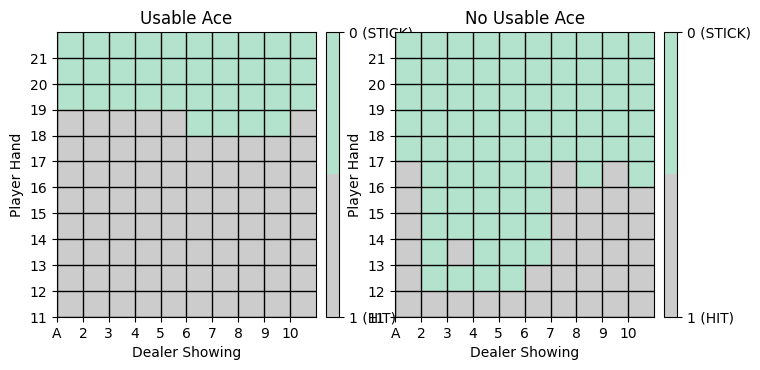

In [14]:
#Costruisci optimal_policy e poi fai il grafico
optimal_policy = {}
for i in optimal_Q:
  optimal_policy[i] = np.argmax(optimal_Q[i])

plot_policy(optimal_policy)

In [15]:
dpq = pd.DataFrame(optimal_Q.items(),columns=['state', 'action'])
dpq.head(9)

,state,action
0,"(19, 10, False)","[-0.04360753221010919, -0.7359232849766415]"
1,"(12, 10, False)","[-0.5711954304365574, -0.4255017230893983]"
2,"(9, 10, False)","[-0.5736213757816947, -0.2556306306306308]"
3,"(18, 7, False)","[0.3970873786407768, -0.6151658767772509]"
4,"(17, 10, True)","[-0.4755927475592748, -0.20949720670391067]"
5,"(16, 1, False)","[-0.7099911582670209, -0.6032028469750887]"
6,"(21, 10, False)","[0.8986543313708998, -1.0]"
7,"(20, 10, False)","[0.44092128095914174, -0.8612155388471164]"
8,"(20, 2, False)","[0.624680306905371, -0.8822815533980582]"


#### Per capire un pò meglio l'inner loop della funzione mc_control_off_policy_importance_sampling

In [37]:
import copy

def mc_off(behaviour_policy, env, discount=1.0, Q = copy.deepcopy(optimal_Q), C = copy.deepcopy(Cw) ):

    C[(9, 10, False)][1] = 0
    target_policy = create_target_policy(Q)

    for i_episode in range(1, 4):

        print(f"\nEP:{i_episode}")
        #Episodi inventati per capire il codice.

        if  i_episode == 1:
            # la prima azione immessa nella sequenza non è greedy, nè apporta un return G sufficentemente grande da renderla tale,
            # e verificare la condizione action == np.argmax(target_policy(state))
            # Per tanto, l'algoritmo aggiorna solo Q dell'ultimo "state" dell'episodio (Nota usando W=1), ignorando il resto dell'episodio
            episode = [((4, 3, True), 1, 70.0),((6, 3, True), 1, 45.0), ((14, 3, True), 1, 0.0), ((12, 10, False), 1, 0.0), ((19, 10, False), 1, 1.0)]

        if i_episode == 2 :
            # la prima azione immessa nella sequenza non è greedy, ma apporta un return G sufficentemente grande da renderla tale.
            # La condizione action == np.argmax(target_policy(state)) è verificata. Si passa allo state successivo.
            # L'azione selezionata non è greedy, la condizione action == np.argmax(target_policy(state)) non è verificata;
            # algoritmo di ferma li, e passa al prossimo episodio
            episode = [((18, 7, False), 0, 70.0), ((12, 10, False), 0, - 3000.0), ((19, 10, False), 1, 3000.0)]

        if i_episode == 3 :
            # tutte le azioni sono greedy, l'algoritmo apprende da tutti gli state dell'episodio
            episode = [((18, 7, False), 0, 0.5), ((9, 10, False), 1, 67.0), ((12, 10, False), 1, 2.5), ((12, 10, False), 1, 0.0), ((20, 10, False), 0, 0.0)]


        print(episode[::-1])

        G = 0.0
        W = 1.0

        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]

            G = discount*G + reward

            print(" ")
            print("G=", G)
            print(f"  IN   Q[{state}] =", Q[state])

            print("IN W=",W)
            C[state][action] = C[state][action] + W
            print(f"C[{state}][{action}] + W = ", C[state][action])
            print(f"(W/C[{state}][{action}]) = ", W/C[state][action])


            print(f"Formula  Q[{state}][{action}] = Q[{state}][{action}] + W/C[{state}][{action}] * (G - Q[{state}][{action}]) ")
            Q[state][action] = Q[state][action]  + (W/C[state][action]) * (G - Q[state][action])
            print(f"  OUT modify Q[{state}][{action}] = ",Q[state][action])


            if action != np.argmax(target_policy(state)):
                print("\t  --- in break ---- ")
                break

            W = W * (target_policy(state)[action]/behaviour_policy(state)[action])
            print("UPDATE W=",W)



    return print("\nEnd")


behaviour_policy = create_behaviour_policy(env.action_space.n)
mc_off( behaviour_policy, env)


EP:1
[((19, 10, False), 1, 1.0), ((12, 10, False), 1, 0.0), ((14, 3, True), 1, 0.0), ((6, 3, True), 1, 45.0), ((4, 3, True), 1, 70.0)]
 
G= 1.0
  IN   Q[(19, 10, False)] = [-0.04360753 -0.73592328]
IN W= 1.0
C[(19, 10, False)][1] + W =  4068.0
(W/C[(19, 10, False)][1]) =  0.0002458210422812193
Formula  Q[(19, 10, False)][1] = Q[(19, 10, False)][1] + W/C[(19, 10, False)][1] * (G - Q[(19, 10, False)][1]) 
  OUT modify Q[(19, 10, False)][1] =  -0.7354965585054083
	  --- in break ---- 

EP:2
[((19, 10, False), 1, 3000.0), ((12, 10, False), 0, -3000.0), ((18, 7, False), 0, 70.0)]
 
G= 3000.0
  IN   Q[(19, 10, False)] = [-0.04360753 -0.73549656]
IN W= 1.0
C[(19, 10, False)][1] + W =  4069.0
(W/C[(19, 10, False)][1]) =  0.0002457606291472106
Formula  Q[(19, 10, False)][1] = Q[(19, 10, False)][1] + W/C[(19, 10, False)][1] * (G - Q[(19, 10, False)][1]) 
  OUT modify Q[(19, 10, False)][1] =  0.0019660850331774116
UPDATE W= 2.0
 
G= 0.0
  IN   Q[(12, 10, False)] = [-0.57119543 -0.42550172]
IN W=

Sempre al fine di capire meglio il codice, sposto la condizione di break dell'inner loop e l'update di W; in modo da far sembrare il tutto più rigorosamente coerente con la teoria probabilistica del weighted importance Sampling: cioè se azione $a_{T-1}$ scelta nello stato dell'episodio $s_{T-1}$ dalla behaviour_policy ha probabilità zero di essere estratta dalla target_policy (quindi $W=0$), allora passa al prossimo episodio, senza aggionarare $Q$ con $G= R_{T}$, e senza aggiornare $C$.

Cosa succede? l'algoritmo non esplora come nel precedente codice ( dove $Q$ ad ogni episodio veniva "inizializzata-aggiornata" nello step : $T-1$) e si polarizza solo sulle azioni considerate greedy.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 250000/300000.


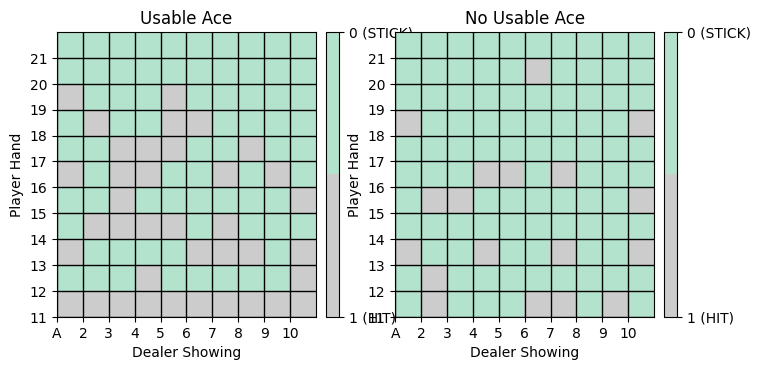

In [43]:
def mc_control_off_policy_importance_sampling1(behaviour_policy, env, num_episodes, discount=1.0):

    # Fase di inizializzazione
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n)) # Somma cumulativa dei weights dell'importance sampling formula
    target_policy = create_target_policy(Q)

    for i_episode in range(1, num_episodes+1):


        if i_episode % 250_000 == 0:
              print("\rEpisode {}/{}.".format(i_episode, num_episodes))


        state = env.reset()
        episode = []
        while(True):
            probs = behaviour_policy(state)  #  probs = [0.5 0.5]
            action = np.random.choice(len(probs), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        G = 0.0
        W = 1.0

        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]

            #       ---
            if action != np.argmax(target_policy(state)):
                break

            W = W*(target_policy(state)[action]/behaviour_policy(state)[action])
            #       ---

            G = discount*G + reward
            C[state][action] = C[state][action] + W

            Q[state][action] = Q[state][action]  + (W/C[state][action]) * (G - Q[state][action])


    return Q,C


behaviour_policy = create_behaviour_policy(env.action_space.n)
#print(behaviour_policy("di tutto")) # [0.5 0.5]
optimal_Q1, Cw1 = mc_control_off_policy_importance_sampling1( behaviour_policy, env, num_episodes=300_000)
#Costruisci optimal_policy e poi fai il grafico

optimal_policy1 = {}
for i in optimal_Q1:
  optimal_policy1[i] = np.argmax(optimal_Q1[i])

plot_policy(optimal_policy1)

In [45]:
dpq1 = pd.DataFrame(Cw1.items(),columns=['state', 'action'])
dpq1.head(30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,state,action
0,"(15, 3, False)","[2.0, 2380.0]"
1,"(10, 6, False)","[1050.0, 4.0]"
2,"(16, 4, False)","[2.0, 2320.0]"
3,"(10, 5, False)","[1046.0, 4.0]"
4,"(14, 6, True)","[214.0, 40.0]"
5,"(17, 4, False)","[2184.0, 2.0]"
6,"(15, 6, True)","[306.0, 12.0]"
7,"(12, 6, False)","[2390.0, 2.0]"
8,"(10, 1, False)","[2.0, 932.0]"
9,"(21, 10, False)","[4864.0, 0.0]"


In [44]:
import copy

def mc_off(behaviour_policy, env, discount=1.0, Q1 = copy.deepcopy(optimal_Q1), C1 = copy.deepcopy(Cw1) ):

    C1[(9, 10, False)][1] = 0
    target_policy = create_target_policy(Q1)

    for i_episode in range(1, 4):

        print(f"\nEP:{i_episode}")
        #Episodi inventati per capire il codice.

        if  i_episode == 1:

            episode = [((4, 3, True), 1, 70.0),((6, 3, True), 1, 45.0), ((14, 3, True), 1, 0.0), ((12, 10, False), 1, 0.0), ((19, 10, False), 1, 1.0)]

        if i_episode == 2 :

            episode = [((18, 7, False), 1, 70.0), ((12, 10, False), 0, - 3000.0), ((19, 10, False), 0, 3000.0)]

        if i_episode == 3 :

            episode = [((18, 7, False), 0, 0.5), ((9, 10, False), 0, 67.0), ((12, 10, False), 0, 2.5), ((12, 10, False), 0, 0.0), ((20, 10, False), 0, 0.0)]


        print(episode[::-1])

        G = 0.0
        W = 1.0

        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]

            if action != np.argmax(target_policy(state)):
                print("\t  --- in break ---- ")
                break

            G = discount*G + reward


            print(" ")
            print("G=", G)
            W = W * (target_policy(state)[action]/behaviour_policy(state)[action])
            print(f"  IN   Q[{state}] =", Q1[state])

            print("IN W=",W)
            C1[state][action] = C1[state][action] + W
            print(f"C[{state}][{action}] + W = ", C1[state][action])
            print(f"(W/C[{state}][{action}]) = ", W/C1[state][action])


            print(f"Formula  Q[{state}][{action}] = Q[{state}][{action}] + W/C[{state}][{action}] * (G - Q[{state}][{action}]) ")
            Q1[state][action] = Q1[state][action]  + (W/C1[state][action]) * (G - Q1[state][action])
            print(f"  OUT modify Q[{state}][{action}] = ",Q1[state][action])





    return print("\nEnd")


behaviour_policy = create_behaviour_policy(env.action_space.n)
mc_off( behaviour_policy, env)


EP:1
[((19, 10, False), 1, 1.0), ((12, 10, False), 1, 0.0), ((14, 3, True), 1, 0.0), ((6, 3, True), 1, 45.0), ((4, 3, True), 1, 70.0)]
	  --- in break ---- 

EP:2
[((19, 10, False), 0, 3000.0), ((12, 10, False), 0, -3000.0), ((18, 7, False), 1, 70.0)]
 
G= 3000.0
  IN   Q[(19, 10, False)] = [-0.00896226 -1.        ]
IN W= 2.0
C[(19, 10, False)][0] + W =  8482.0
(W/C[(19, 10, False)][0]) =  0.0002357934449422306
Formula  Q[(19, 10, False)][0] = Q[(19, 10, False)][0] + W/C[(19, 10, False)][0] * (G - Q[(19, 10, False)][0]) 
  OUT modify Q[(19, 10, False)][0] =  0.698420183918887
 
G= 0.0
  IN   Q[(12, 10, False)] = [-0.58630528 -1.        ]
IN W= 4.0
C[(12, 10, False)][0] + W =  9818.0
(W/C[(12, 10, False)][0]) =  0.00040741495212874313
Formula  Q[(12, 10, False)][0] = Q[(12, 10, False)][0] + W/C[(12, 10, False)][0] * (G - Q[(12, 10, False)][0]) 
  OUT modify Q[(12, 10, False)][0] =  -0.5860664086371975
	  --- in break ---- 

EP:3
[((20, 10, False), 0, 0.0), ((12, 10, False), 0, 0.0), ((